# Used car sales machine learning

## Load in data

In [1]:
##Load in cleaned data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cars = pd.read_csv('cleaned_vehicles.csv')

print("Number of features: " +str(len(cars.columns)))
print("Number of rows: "+str(len(cars)))
print("\n")                

Number of features: 544
Number of rows: 316984




## Split data into train and test sets

In [3]:
cars = cars.sample(frac=1, random_state=2)
train, test = np.split(cars,  [int(.8*len(cars))])

train.to_csv(r'train_vehicles.csv', index = False, header=True)
test.to_csv(r'test_vehicles.csv', index = False, header=True)

print(len(train))
print(len(test))

trainX = train.drop(['price'], axis=1)
trainY = train['price']

testX = test.drop(['price'], axis=1)
testY = test['price']

253587
63397


## Short list promising models

In [23]:
from sklearn.model_selection import KFold
import scipy.stats as stats
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


def testModelswithCrossVal(models, X, Y, k=10):
    MSEDict = defaultdict(list)
    modelsDict = defaultdict(list)
    
    
    kf = KFold(n_splits=k)
    kIndexes = kf.split(X)
    
    for train_index, val_index in tqdm(kIndexes):
        
        x_train = X.iloc[train_index]
        y_train =  Y.iloc[train_index]
        
        x_val = X.iloc[val_index]
        y_val =  Y.iloc[val_index]
        
        for model in tqdm(models):
            learnedModel = model.fit(x_train, y_train)
            valPredict = learnedModel.predict(x_val)
            
            modelsDict[model.__class__.__name__].append(learnedModel)
            MSEDict[model.__class__.__name__].append(mean_squared_error(y_val, valPredict))
        
        
    return MSEDict, modelsDict

### Train many small and quick models

This includes, linear regression, MLP, decision trees and ensemble methods such as bagging and boosting (Adaboost and XGBoost)

In [24]:
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


models = []
models.append(linear_model.LinearRegression())
models.append(linear_model.Lasso())
models.append(linear_model.Ridge())
models.append(MLPRegressor())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())
models.append(AdaBoostRegressor())
models.append(XGBRegressor())


MSEDict, modelsDict = testModelswithCrossVal(models, trainX, trainY)    

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:54<00:00, 186.76s/it]
1it [24:54, 1494.38s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:37<00:00, 184.74s/it]
2it [49:32, 1489.55s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [23:32<00:00, 176.54s/it]
3it [1:13:05, 1466.48s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:25<00:00, 183.19s/it]
4it [1:37:31, 1466.30s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:42<00:00, 185.31s/it]
5it [2:02:14, 1471.25s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [24:12<00:00, 181.62s/it]
6it [2:26:27, 1465.88s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [25:11<00

### Evaluate all the models

######LinearRegression######
Mean MSE: 1.9987262379485533e+17
STD of MSE: 1.594351029692912e+35
Top 5 Features: {'title_status_salvage', 'title_status_rebuilt', 'title_status_missing', 'title_status_parts only', 'title_status_clean'}


######Lasso######
Mean MSE: 0.011420985993680039
STD of MSE: 2.7225946291961746e-08
Top 5 Features: {'region_kansas city, MO', 'region_lake charles', 'region_kenai peninsula', 'state_wy', 'region_kansas city'}


######Ridge######
Mean MSE: 0.004780271108466277
STD of MSE: 1.2544832766514831e-08
Top 5 Features: {'odometer', 'year', 'manufacturer_tesla', 'manufacturer_morgan', 'manufacturer_ferrari'}


######MLPRegressor######
Mean MSE: 0.0029219114244437485
STD of MSE: 7.385103018630683e-09
Top 5 Features: {'N/A'}


######DecisionTreeRegressor######
Mean MSE: 0.00378933113739309
STD of MSE: 1.0716051555978928e-08
Top 5 Features: {'odometer', 'cylinders', 'drive_fwd', 'year', 'fuel_diesel'}


######RandomForestRegressor######
Mean MSE: 0.002214648019041765

Text(0.5, 0, 'MSE')

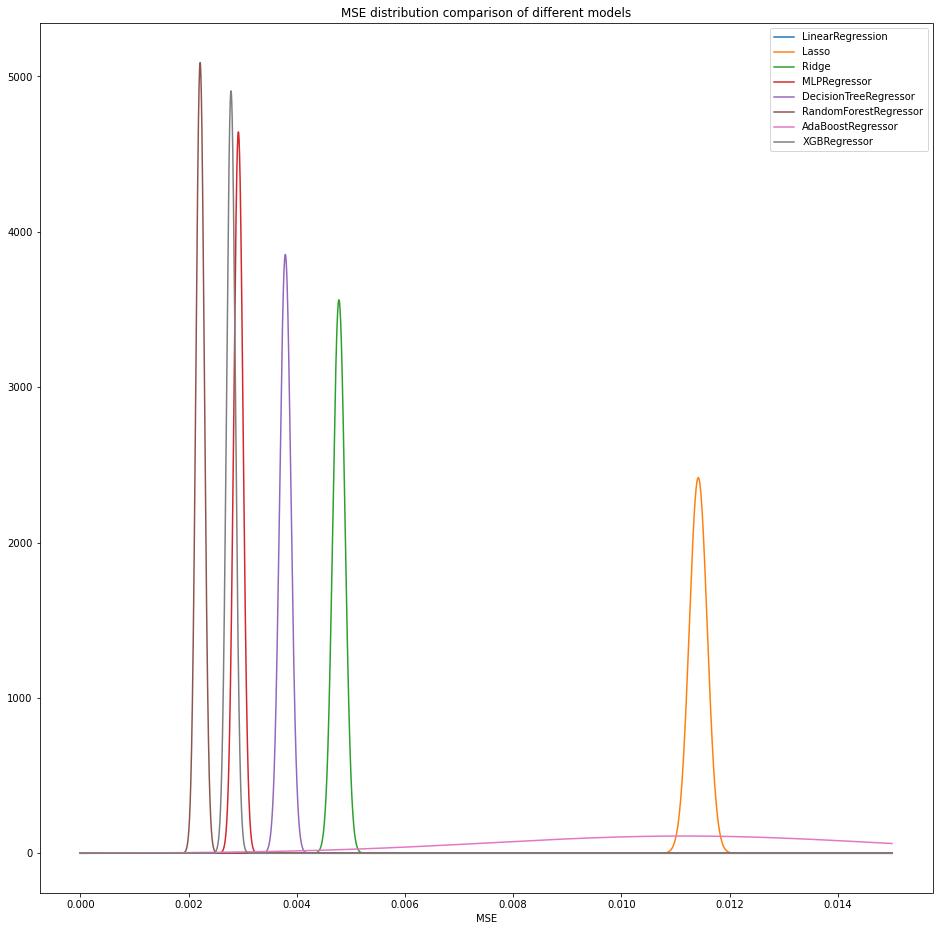

In [48]:
##Explore learned models
import heapq
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
%matplotlib inline

features = trainX.columns

##Plot respective distributions of models over k-fold cross validation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16))
x = np.linspace(0,0.015, 10000)

for model in MSEDict:
    learnedModels = modelsDict[model]
    mean = np.asarray(MSEDict[model]).mean()
    std = np.asarray(MSEDict[model]).std()
    var = np.asarray(MSEDict[model]).var()
    
    print("######"+str(model)+"######")
    print('Mean MSE: '+str(mean))
    print('STD of MSE: '+str(var))
    
    topFeatures = set()
    numFeatures=5
    for learnedModel in learnedModels:
        try:
            coef = [abs(k) for k in learnedModel.coef_]
            top3 = np.flip(np.argsort(coef)[-numFeatures:])
            top3features = [features[k] for k in top3]
            topFeatures.update(top3features)
        except:
            try:
                importances = learnedModel.feature_importances_
                indices = np.argsort(importances)
                top3features = [features[k] for k in indices[-numFeatures:]]
                topFeatures.update(top3features)
                    
            except:
                topFeatures.add('N/A')
    print('Top '+str(numFeatures)+' Features: '+str(topFeatures))
    print('\n')
    ax.plot(x, stats.norm.pdf(x, mean, math.sqrt(var)), label=model)
ax.legend()
ax.set_title("MSE distribution comparison of different models")
ax.set_xlabel("MSE")

Clearly, the Random Forests, XGBoost and MLP are the most promising models.

## Finetuning promising models